In [ ]:
# Standard libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Kaggle utility
import kagglehub

# Scikit-learn utilities for building pipelines and transformers
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Scikit-learn for preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.impute import SimpleImputer

# Scikit-learn models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR

# Scikit-learn model selection tools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Scikit-learn metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc

# Scikit-learn for multiclass strategies
from sklearn.multiclass import OneVsRestClassifier


In [ ]:
path = kagglehub.dataset_download("mirichoi0218/insurance")
data = pd.read_csv(path + "/insurance.csv")
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [ ]:
#descripción del dataset
print(data.head())
print(data.info())
print(data.describe())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000 

In [ ]:
#verificación de valores nulos y duplicados
print(f"Cantidad de datos ausentes: {data.isnull().sum().sum()}")
print(f"Cantidad de datos duplicados: {data.duplicated().sum()}")

Cantidad de datos ausentes: 0
Cantidad de datos duplicados: 1


In [ ]:
#se eliminan valores duplicados
data = data.drop_duplicates()
print(data.duplicated().sum())

0


# Visualization

In [ ]:
feature_columns = data.columns.tolist()
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
numerical_columns = [col for col in feature_columns if col not in categorical_columns]
print(f"Columnas categóricas: {categorical_columns}")
print(f"Columnas numéricas: {numerical_columns}")

Columnas categóricas: ['sex', 'smoker', 'region']
Columnas numéricas: ['age', 'bmi', 'children', 'charges']


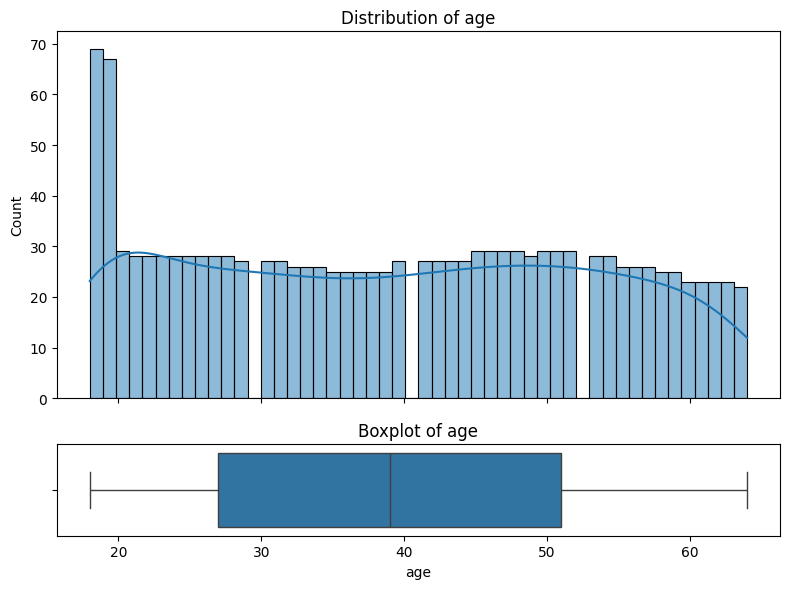

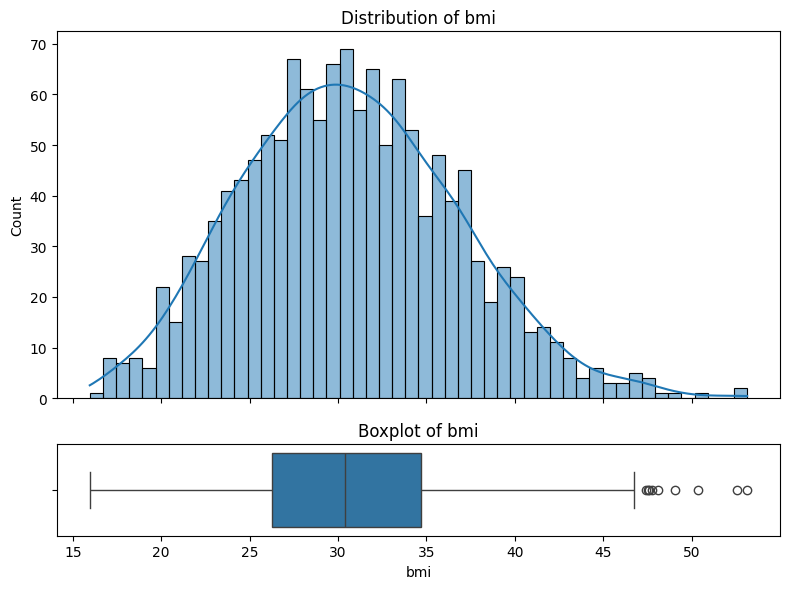

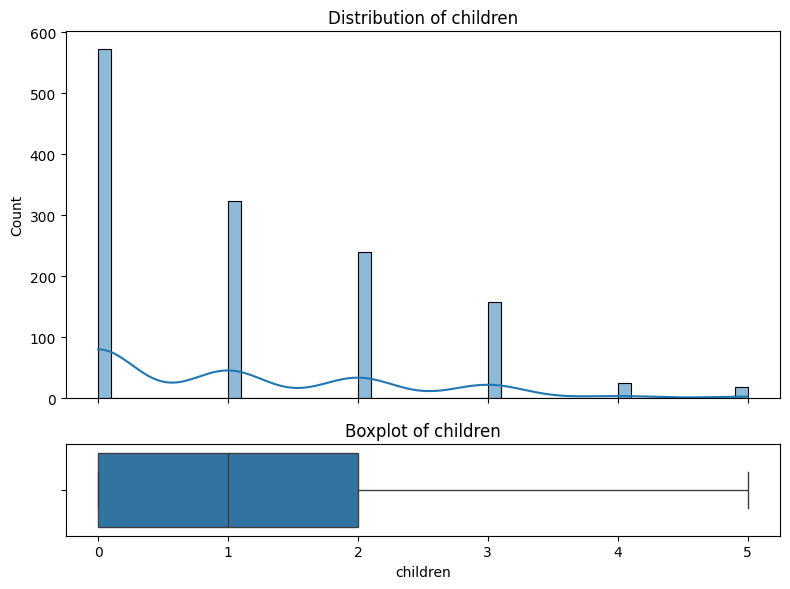

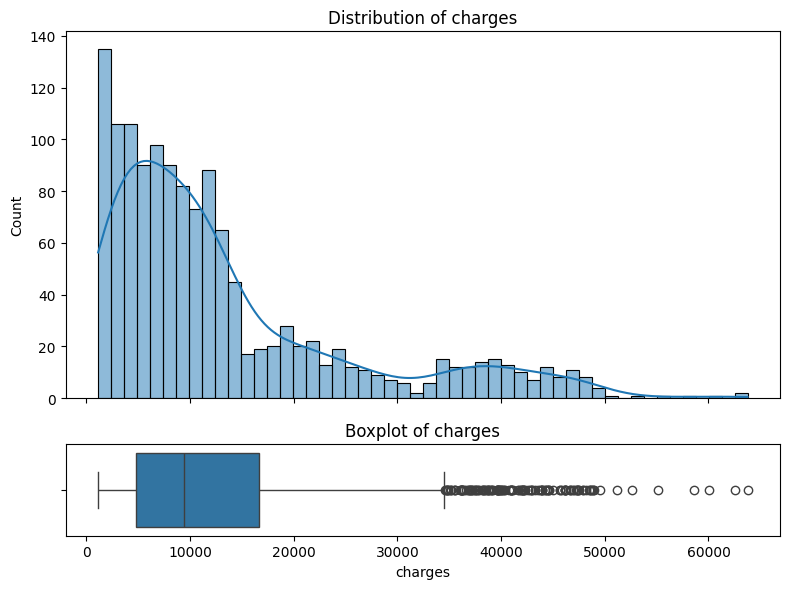

In [ ]:
def plot_distribution(data, column_name, bins=20):
    """
    Esta función genera un histograma y un boxplot para una columna numérica específica de un DataFrame.

    Parameters:
    - data: DataFrame de pandas que contiene los datos.
    - column_name: Nombre de la columna numérica que se va a graficar.
    - bins: Número de bins (intervalos) para el histograma. Valor predeterminado es 20.

    Returns:
    - Una figura con dos gráficos: un histograma y un boxplot.
    """
    # Crear una figura con dos subplots: 1 fila, 1 columna y diferentes alturas
    fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True,
                                          gridspec_kw={"height_ratios": (4, 1)}, figsize=(8,6))

    # Histograma en el eje superior
    sns.histplot(data[column_name], bins=bins, kde=True, ax=ax_hist)
    ax_hist.set_title(f'Distribution of {column_name}')

    # Boxplot en el eje inferior (más compacto)
    sns.boxplot(x=data[column_name], ax=ax_box)
    ax_box.set_title(f'Boxplot of {column_name}')

    # Ajustar los gráficos
    plt.tight_layout()
    plt.show()

for column in numerical_columns:
    plot_distribution(data, column, bins=50)

1. Distribuciones generales:

Las variables age, bmi, y children tienen distribuciones esperadas en el contexto del dataset. Sin embargo, charges presenta una alta variabilidad, con valores extremos que pueden impactar los análisis.
Valores atípicos:

2. Se observan valores atípicos en bmi y charges. }

3. Sesgos:

charges está fuertemente sesgado a la derecha. Esto podría requerir una transformación (por ejemplo, logarítmica) si se utiliza en modelos de machine learning.


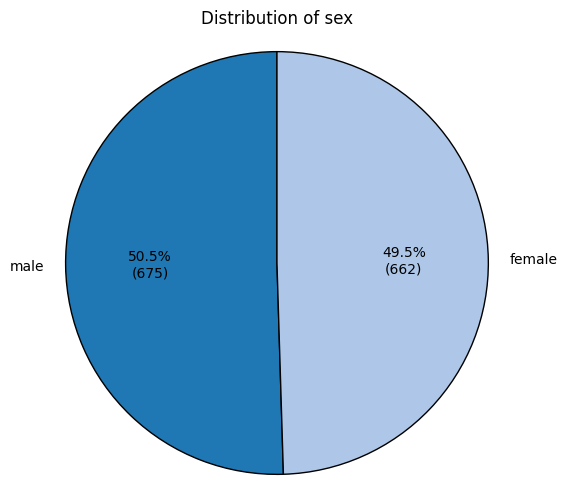

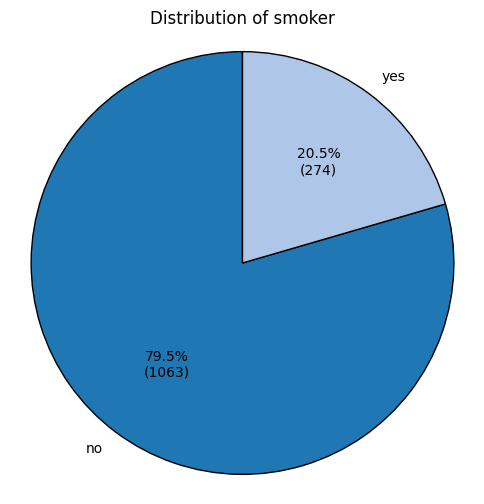

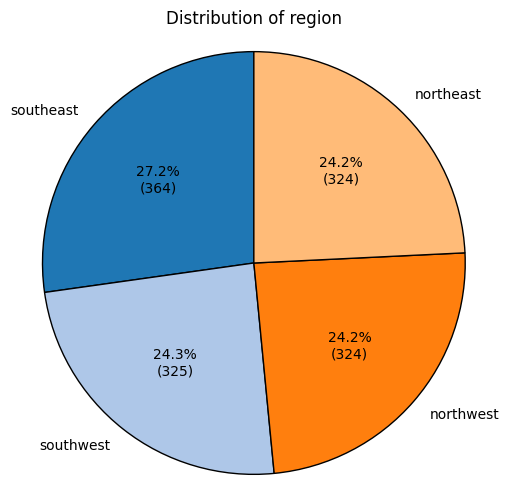

In [ ]:
def plot_pie_chart(data_series, title="Distribution"):
    """
    Genera un gráfico circular con colores únicos automáticamente generados para cada categoría.

    Parameters:
    - data_series: Serie de pandas con los datos y etiquetas a graficar.
    - title: Título del gráfico (opcional).

    Returns:
    - Un gráfico circular con porcentajes y conteos.
    """
    # Generar una lista de colores única para cada categoría
    colors = plt.cm.tab20.colors[:len(data_series)]  # Ajusta la paleta si necesitas más colores

    def autopct_format(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            return f'{pct:.1f}%\n({val})'
        return my_autopct

    plt.figure(figsize=(6,6))
    plt.pie(data_series, labels=data_series.index, autopct=autopct_format(data_series),
            startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})

    plt.title(title)
    plt.axis('equal')
    plt.show()

for column in categorical_columns:
    plot_pie_chart(data[column].value_counts(), title=f'Distribution of {column}')

# Correlación

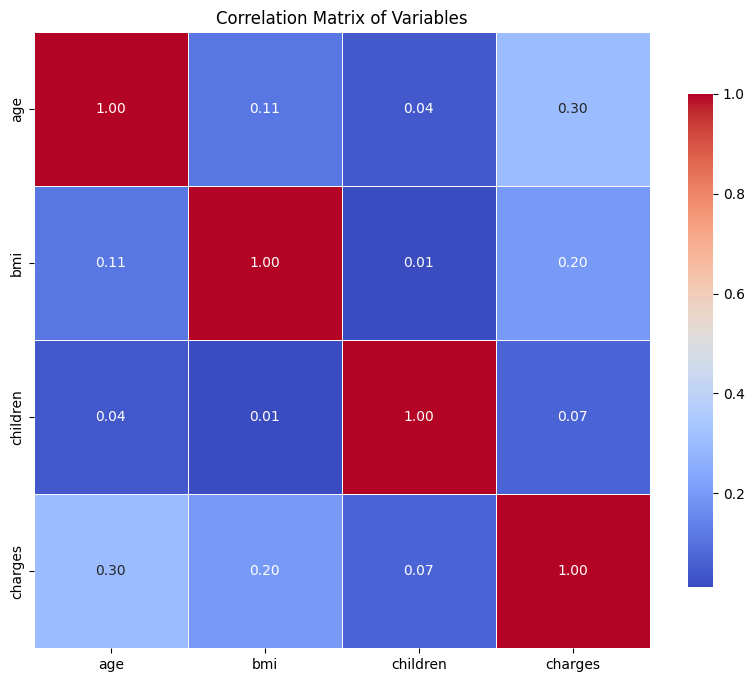

In [ ]:
def plot_correlation_matrix(data, title="Correlation Matrix", cmap="coolwarm", annot=True):
    """
    Genera un gráfico de mapa de calor de la matriz de correlación de un DataFrame.

    Parameters:
    - data: DataFrame de pandas con los datos.
    - title: Título del gráfico (opcional).
    - cmap: Paleta de colores para el mapa de calor (opcional, predeterminado 'coolwarm').
    - annot: Si True, muestra los valores de correlación en cada celda (opcional, predeterminado True).

    Returns:
    - Un gráfico de mapa de calor de la matriz de correlación.
    """
    # Calcular la matriz de correlación
    corr_matrix = data.corr()

    # Configurar la figura
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=annot, cmap=cmap, square=True,
                linewidths=0.5, fmt=".2f", cbar_kws={"shrink": .8})

    # Título y ajuste de la visualización
    plt.title(title)
    plt.show()

plot_correlation_matrix(data[numerical_columns], title="Correlation Matrix of Variables")

1. **Edad (age) y costos médicos (charges):** Correlación moderada positiva (0.30), indicando que los costos médicos aumentan ligeramente con la edad.

2. **BMI y costos médicos:** Correlación débil positiva (0.20), sugiriendo que un índice de masa corporal más alto puede influir levemente en los costos médicos.

3. **Hijos (children) y costos médicos:** Correlación insignificante (0.07), mostrando que el número de hijos no tiene un impacto notable en los costos médicos.

4. **Relaciones entre variables independientes: **Muy bajas, indicando que son prácticamente independientes entre sí.

**Conclusión:** Los costos médicos están influenciados principalmente por la edad y, en menor medida, por el BMI. El número de hijos no tiene impacto relevante.

# Outliers

In [1]:
# Función para identificar outliers usando IQR
def identify_outliers_iqr(df, columns):
    outlier_indices = []
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Definición de límites
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identificación de outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_indices.extend(outliers.index.tolist())

    return set(outlier_indices)

# Identificando outliers en las variables numéricas
outlier_indices = identify_outliers_iqr(data, numerical_columns)
num_outliers = len(outlier_indices)
num_data = len(data)

print(f"Número total de outliers identificados: {num_outliers}")
print(f"Porcentaje de outliers: {(num_outliers / num_data) * 100:.2f}%")

NameError: name 'data' is not defined

# Variable de Interes

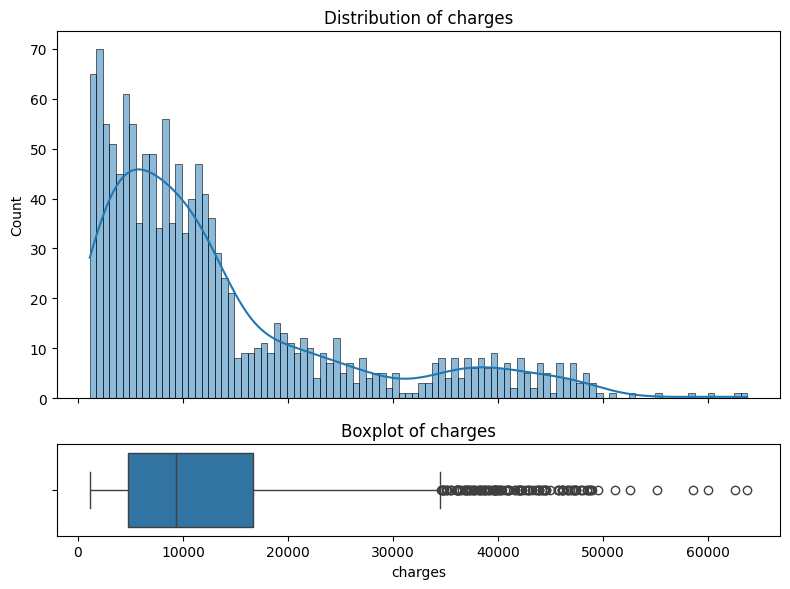

In [ ]:
plot_distribution(data, 'charges', bins=100)

La variable charges tiene una distribución asimétrica con muchos valores bajos y unos pocos costos extremadamente altos que dominan la cola derecha
1. La distribución está sesgada a la derecha. La mayoría de los costos médicos están concentrados por debajo de $15,000.
2. Hay una cola larga con valores más altos, lo que indica la presencia de pocos casos con costos muy elevado
3. Existen muchos valores atípicos (outliers) por encima de $30,000, representando casos extremos en costos médicos.

# Dividir Dataset

In [ ]:
# Dividir los datos en características (X) y etiqueta objetivo (y)
X = data.drop('charges', axis=1)
y = data['charges']

# Identificar columnas numéricas y categóricas
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

# Dividir los datos en conjunto de entrenamiento, validación y prueba
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_columns),  # Pasar columnas numéricas sin cambios
        ('cat', OneHotEncoder(drop='first'), categorical_columns)  # Codificar categóricas
    ]
)

# Crear el pipeline que combina el preprocesador y el modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Entrenar el modelo en el conjunto de entrenamiento
pipeline.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de validación
y_train_pred = pipeline.predict(X_train)
y_val_pred = pipeline.predict(X_val)

train_score = pipeline.score(X_train, y_train)
val_score = pipeline.score(X_val, y_val)

train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)

# Evaluar el modelo en el conjunto de prueba
y_test_pred = pipeline.predict(X_test)
test_score = pipeline.score(X_test, y_test)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# Resultados
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_val)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")
print(f"R² Score en entrenamiento: {train_score}")
print(f"R² Score en validación: {val_score}")
print(f"R² Score en prueba: {test_score}")
print(f"RMSE en entrenamiento: {train_rmse}")
print(f"RMSE en validación: {val_rmse}")
print(f"RMSE en prueba: {test_rmse}")

Tamaño del conjunto de entrenamiento: 801
Tamaño del conjunto de validación: 268
Tamaño del conjunto de prueba: 268
R² Score en entrenamiento: 0.7315026287772068
R² Score en validación: 0.7211036271515101
R² Score en prueba: 0.8057067181435495
RMSE en entrenamiento: 6175.140706590151
RMSE en validación: 5806.051653867958
RMSE en prueba: 5975.162654151709


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
print(X_train.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
dtype: object


# Transformadores

In [ ]:
# Creación de pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Ajustar el pipeline a los datos de entrenamiento:
pipeline.fit(X_train, y_train)

# Realizar predicciones utilizando el pipeline
y_train_pred = pipeline.predict(X_train)

In [ ]:
class OutlierRemoverIQR(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        # Verifica que el input sea un DataFrame de pandas
        if not isinstance(X, pd.DataFrame):
            raise ValueError("El input debe ser un DataFrame de pandas")

        # Calcula los límites para cada columna usando IQR
        self.lower_bounds_ = {}
        self.upper_bounds_ = {}

        for col in self.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1

            # Definir límites
            self.lower_bounds_[col] = Q1 - 1.5 * IQR
            self.upper_bounds_[col] = Q3 + 1.5 * IQR

        return self

    def transform(self, X):
        # Identificar y eliminar las filas que contienen outliers
        X = X.copy()
        for col in self.columns:
            lower_bound = self.lower_bounds_[col]
            upper_bound = self.upper_bounds_[col]
            X = X[(X[col] >= lower_bound) & (X[col] <= upper_bound)]

        # Restablecer índices tras la eliminación
        return X.reset_index(drop=True)

In [ ]:
# Paso 1: Combinar X_train e y_train en un solo DataFrame temporal
train_data = X_train.copy()
train_data['target'] = y_train      # Asumiendo que `y_train` es una Serie

# Paso 2: Aplicar el transformador de outliers solo en las columnas numéricas
outlier_remover = OutlierRemoverIQR(columns=numerical_columns)
train_data_no_outliers = outlier_remover.fit_transform(train_data)

# Paso 3: Separar nuevamente `X_train_no_outliers` y `y_train_no_outliers`
X_train_no_outliers = train_data_no_outliers.drop(columns=['target']).reset_index(drop=True)
y_train_no_outliers = train_data_no_outliers['target'].reset_index(drop=True)

In [ ]:
num_transform = StandardScaler()
cat_transform = OneHotEncoder(drop='first')

# Pipeline
# num_pipeline = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
# ])

# cat_pipeline = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('encoder', OneHotEncoder(drop='first'))
# ])

# Crear el `ColumnTransformer` para aplicar los transformadores en cada tipo de columna
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transform, numerical_columns),
        ('cat', cat_transform, categorical_columns)
    ]
)

# Paso 5: Aplicar el preprocesamiento a los datos de entrenamiento, validación y prueba
X_train_transformed = preprocessor.fit_transform(X_train_no_outliers)
X_val_transformed = preprocessor.transform(X_val)

In [ ]:
X_train_transformed.shape

(796, 8)

# Regression

In [ ]:
def plot_regression_results(y_true, y_pred):
    """
    Genera gráficos para evaluar el desempeño de un modelo de regresión:
    1. Gráfico Real vs. Predicho.
    2. Distribución de los Residuales.
    3. Gráfico de Dispersión de Residuales.

    Parámetros:
    - y_true: Valores reales.
    - y_pred: Valores predichos por el modelo.
    """

    # Calcular los residuales
    residuals = y_true - y_pred

    # Configuración de los subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Gráfico 1: Real vs. Predicho
    axs[0].scatter(y_true, y_pred, color='blue', edgecolor='k', alpha=0.6)
    axs[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)  # Línea ideal
    axs[0].set_xlabel("Valores Reales")
    axs[0].set_ylabel("Valores Predichos")
    axs[0].set_title("Valores Reales vs. Predichos")
    axs[0].grid(True)

    # Gráfico 2: Distribución de los Residuales
    sns.histplot(residuals, kde=True, color='purple', bins=30, ax=axs[1])
    axs[1].set_xlabel("Error de Predicción (Residual)")
    axs[1].set_ylabel("Frecuencia")
    axs[1].set_title("Distribución de los Residuales")
    axs[1].grid(True)

    # Gráfico 3: Dispersión de Residuales
    axs[2].scatter(y_pred, residuals, color='purple', edgecolor='k', alpha=0.6)
    axs[2].axhline(0, color='red', linestyle='--')
    axs[2].set_xlabel("Valores Predichos")
    axs[2].set_ylabel("Residuales")
    axs[2].set_title("Dispersión de Residuales")
    axs[2].grid(True)

    # Ajuste de espacios entre subplots
    plt.tight_layout()
    plt.show()

In [ ]:
def train_and_evaluate(pipeline, X_train, y_train, X_val, y_val, log_transform=False):
    """
    Entrena un modelo y evalúa su desempeño en un conjunto de validación.

    Parámetros:
    - pipeline: Pipeline de scikit-learn que incluye preprocesamiento y modelo.
    - X_train: Conjunto de entrenamiento de características.
    - y_train: Conjunto de entrenamiento de etiquetas.
    - X_val: Conjunto de validación de características.
    - y_val: Conjunto de validación de etiquetas.
    - log_transform: Booleano, si es True, aplica logaritmo a y_train para entrenamiento.

    Retorna:
    - mse, rmse, r2: Métricas de evaluación.
    """
    # Aplicar logaritmo a `y_train` si se especifica
    if log_transform:
        y_train = np.log(y_train)

    # Entrenar el modelo
    pipeline.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de validación
    y_val_pred = pipeline.predict(X_val)

    # Aplicar la transformación inversa si se usó logaritmo
    if log_transform:
        y_val_pred = np.exp(y_val_pred)

    # Calcular métricas de desempeño
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_val_pred)

    # Imprimir resultados
    print("Desempeño del modelo en el conjunto de validación:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")

    # Graficar los resultados
    plot_regression_results(y_val, y_val_pred)

    return mse, rmse, r2


# Pipeline 1: Regression

Desempeño del modelo en el conjunto de validación:
Mean Squared Error (MSE): 33681307.10
Root Mean Squared Error (RMSE): 5803.56
R-squared (R2): 0.72


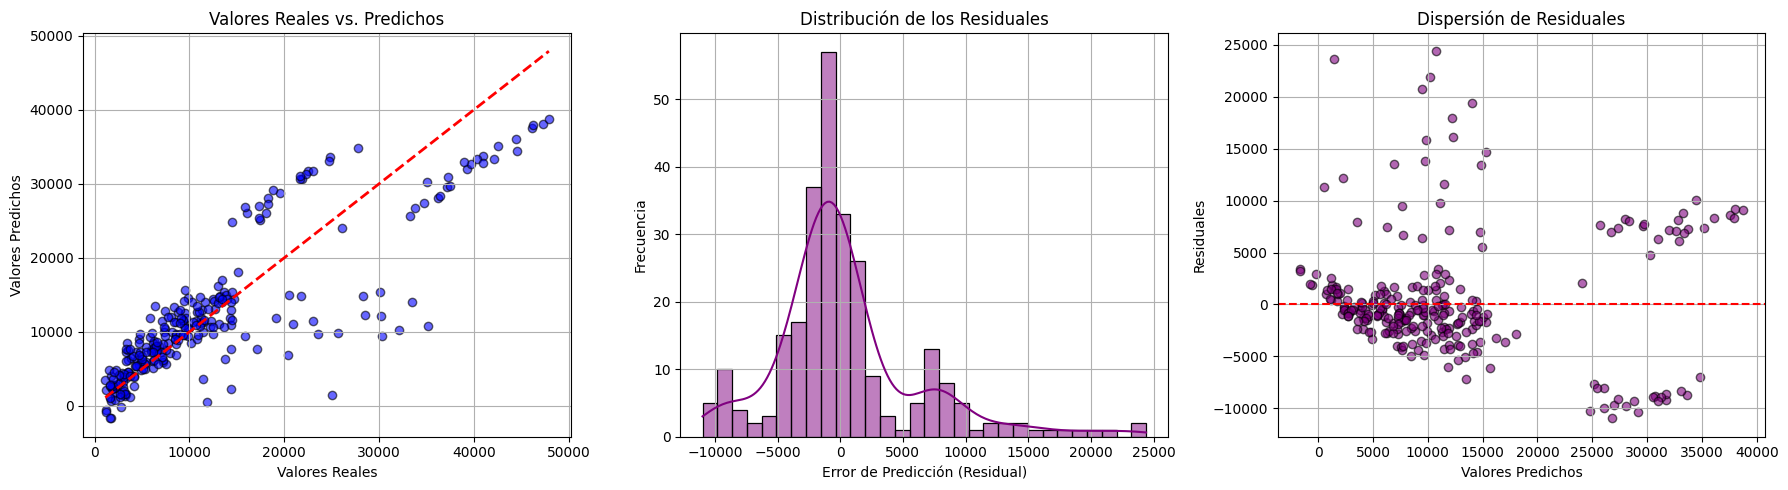

In [ ]:
# Pipeline con preprocesador y modelo de regresión lineal
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Entrenar y evaluar sin logaritmo
mse, rmse, r2 = train_and_evaluate(linear_pipeline, X_train_no_outliers, y_train_no_outliers, X_val, y_val)

# Pipeline 2: Log-Regression

Desempeño del modelo en el conjunto de validación:
Mean Squared Error (MSE): 58691837.46
Root Mean Squared Error (RMSE): 7661.06
R-squared (R2): 0.51


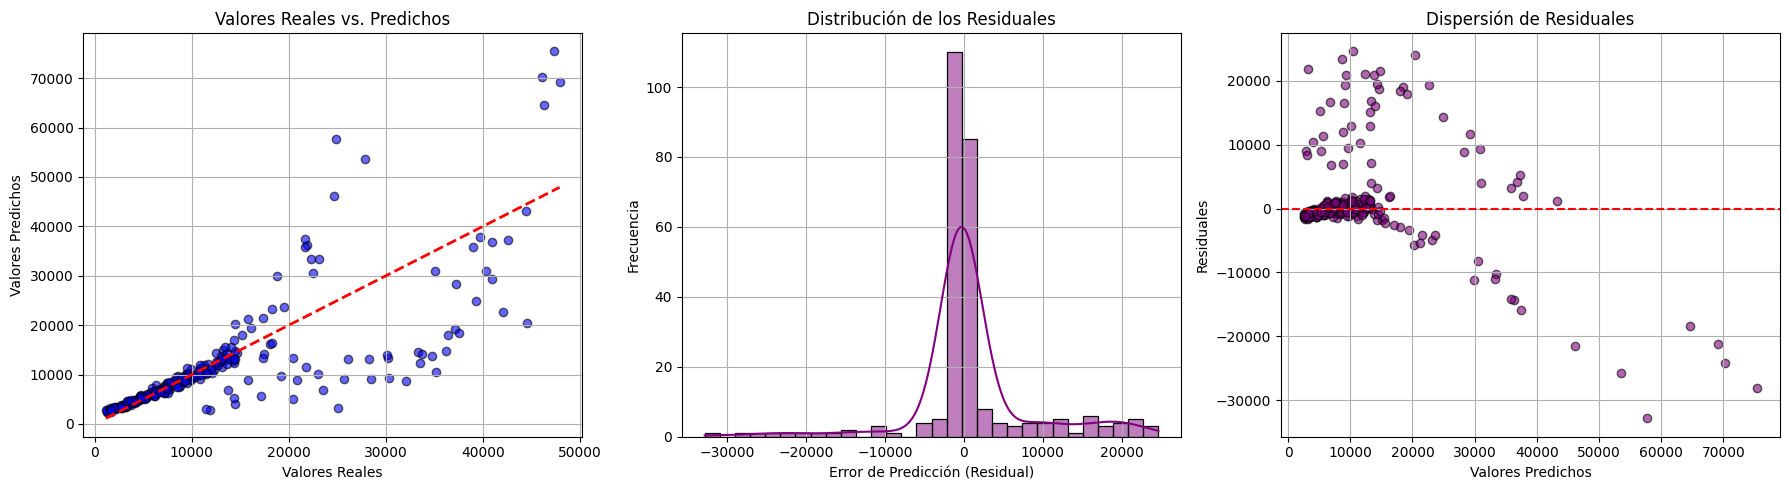

In [ ]:
# Entrenar y evaluar con logaritmo
mse, rmse, r2 = train_and_evaluate(linear_pipeline, X_train_no_outliers, y_train_no_outliers, X_val, y_val, log_transform=True)

# Pipeline 3: Random Forest Regression

Desempeño del modelo en el conjunto de validación:
Mean Squared Error (MSE): 26286236.29
Root Mean Squared Error (RMSE): 5127.01
R-squared (R2): 0.78


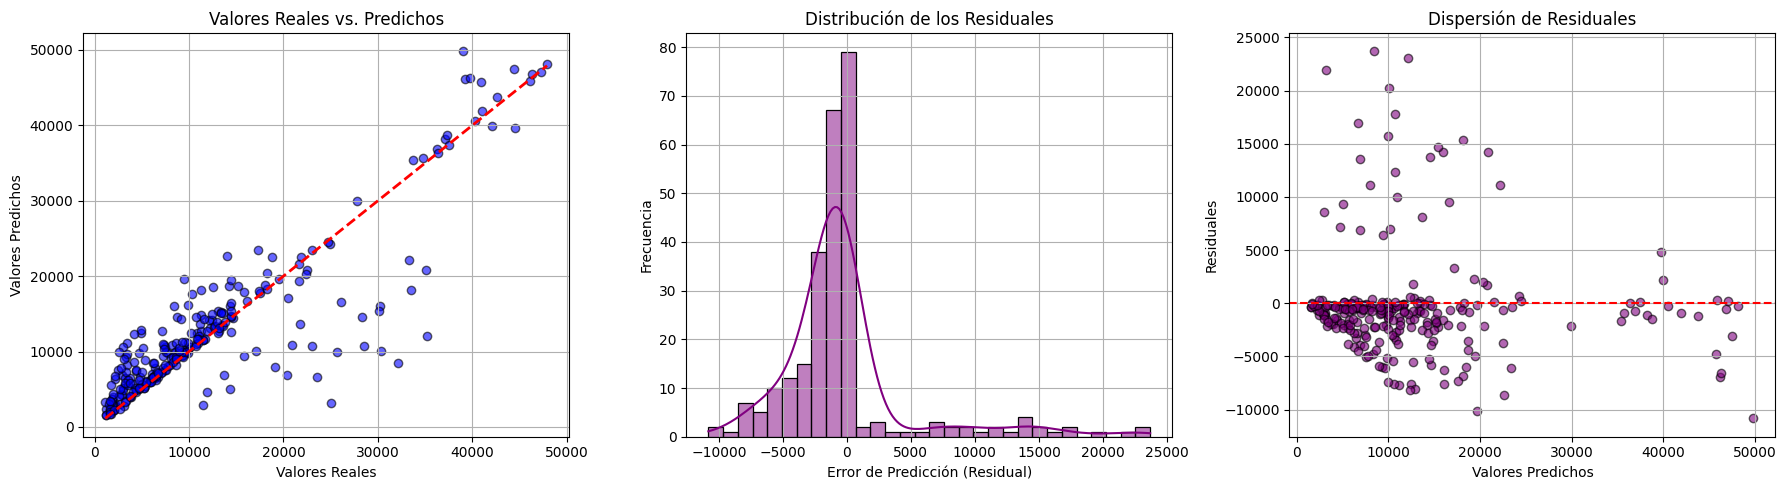

In [ ]:
forest_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Entrenar y evaluar sin logaritmo
mse, rmse, r2 = train_and_evaluate(forest_reg_pipeline, X_train_no_outliers, y_train_no_outliers, X_val, y_val)

# Pipeline 4: Log Random Forest Regression

Desempeño del modelo en el conjunto de validación:
Mean Squared Error (MSE): 23955425.11
Root Mean Squared Error (RMSE): 4894.43
R-squared (R2): 0.80


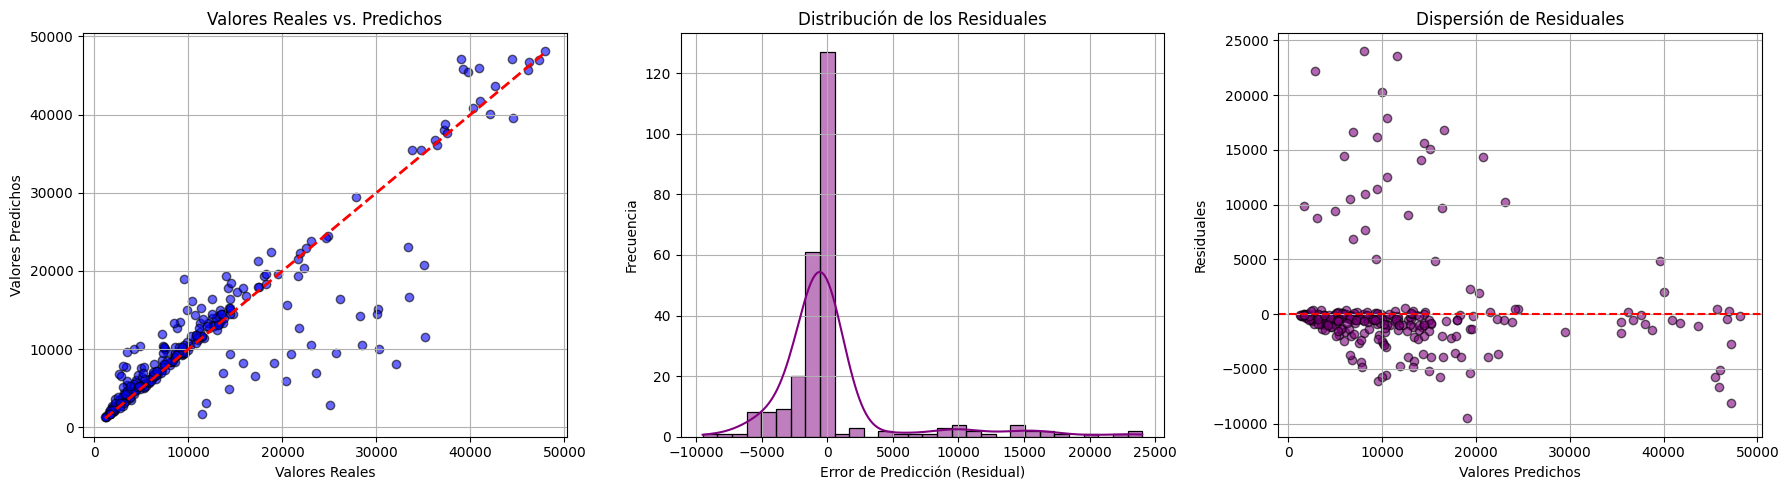

In [ ]:
mse, rmse, r2 = train_and_evaluate(forest_reg_pipeline, X_train_no_outliers, y_train_no_outliers, X_val, y_val, log_transform=True)

# Grid Search Cross Validation





In [ ]:
# Crear un diccionario de modelos con sus respectivos pipelines y posibles parámetros de grid search
model_configs = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}
    },
    "Linear Regression (log-transform)": {
        "model": LinearRegression(),
        "params": {},
        "log_transform": True
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            'regressor__max_depth': [None, 10, 20, 30],
            'regressor__min_samples_split': [2, 5, 10]
        }
    },
    "Decision Tree (log-transform)": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            'regressor__max_depth': [None, 10, 20, 30],
            'regressor__min_samples_split': [2, 5, 10]
        },
        "log_transform": True
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            'regressor__n_estimators': [100, 200],
            'regressor__max_depth': [None, 10, 20],
            'regressor__min_samples_split': [2, 5]
        }
    },
    "Random Forest (log-transform)": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            'regressor__n_estimators': [100, 200],
            'regressor__max_depth': [None, 10, 20],
            'regressor__min_samples_split': [2, 5]
        },
        "log_transform": True
    },
    "SVM": {
        "model": SVR(),
        "params": {
            'regressor__C': [0.1, 1, 10],
            'regressor__kernel': ['linear', 'rbf']
        }
    },
    "SVM (log-transform)": {
        "model": SVR(),
        "params": {
            'regressor__C': [0.1, 1, 10],
            'regressor__kernel': ['linear', 'rbf']
        },
        "log_transform": True
    },
    "KNN": {
        "model": KNeighborsRegressor(),
        "params": {
            'regressor__n_neighbors': [3, 5, 7],
            'regressor__weights': ['uniform', 'distance']
        }
    },
    "KNN (log-transform)": {
        "model": KNeighborsRegressor(),
        "params": {
            'regressor__n_neighbors': [3, 5, 7],
            'regressor__weights': ['uniform', 'distance']
        },
        "log_transform": True
    }
}


In [ ]:
def grid_search_and_evaluate(model_configs, X_train, y_train, X_val, y_val):
    results = {}
    for model_name, config in model_configs.items():
        print(f"\nEntrenando y evaluando modelo: {model_name}")

        # Configuración del preprocesador y pipeline para cada modelo
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', config["model"])
        ])

        # Transformación logarítmica si está especificado
        log_transform = config.get("log_transform", False)
        y_train_transformed = np.log(y_train) if log_transform else y_train

        # Configurar GridSearchCV
        grid_search = GridSearchCV(
            pipeline,
            param_grid=config["params"],
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )

        # Entrenar GridSearchCV
        grid_search.fit(X_train, y_train_transformed)

        # Mejor pipeline obtenido
        best_pipeline = grid_search.best_estimator_

        # Realizar predicciones en el conjunto de validación
        y_val_pred = best_pipeline.predict(X_val)
        if log_transform:
            y_val_pred = np.exp(y_val_pred)

        # Calcular métricas
        mse = mean_squared_error(y_val, y_val_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val, y_val_pred)

        # Guardar los resultados
        results[model_name] = {
            "best_params": grid_search.best_params_,
            "mse": mse,
            "rmse": rmse,
            "r2": r2
        }

        print(f"Mejores parámetros para {model_name}: {grid_search.best_params_}")
        print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

        # Generar gráficos para cada modelo
        plot_regression_results(y_val, y_val_pred)

    return results



Entrenando y evaluando modelo: Linear Regression
Mejores parámetros para Linear Regression: {}
MSE: 33681307.10, RMSE: 5803.56, R2: 0.72


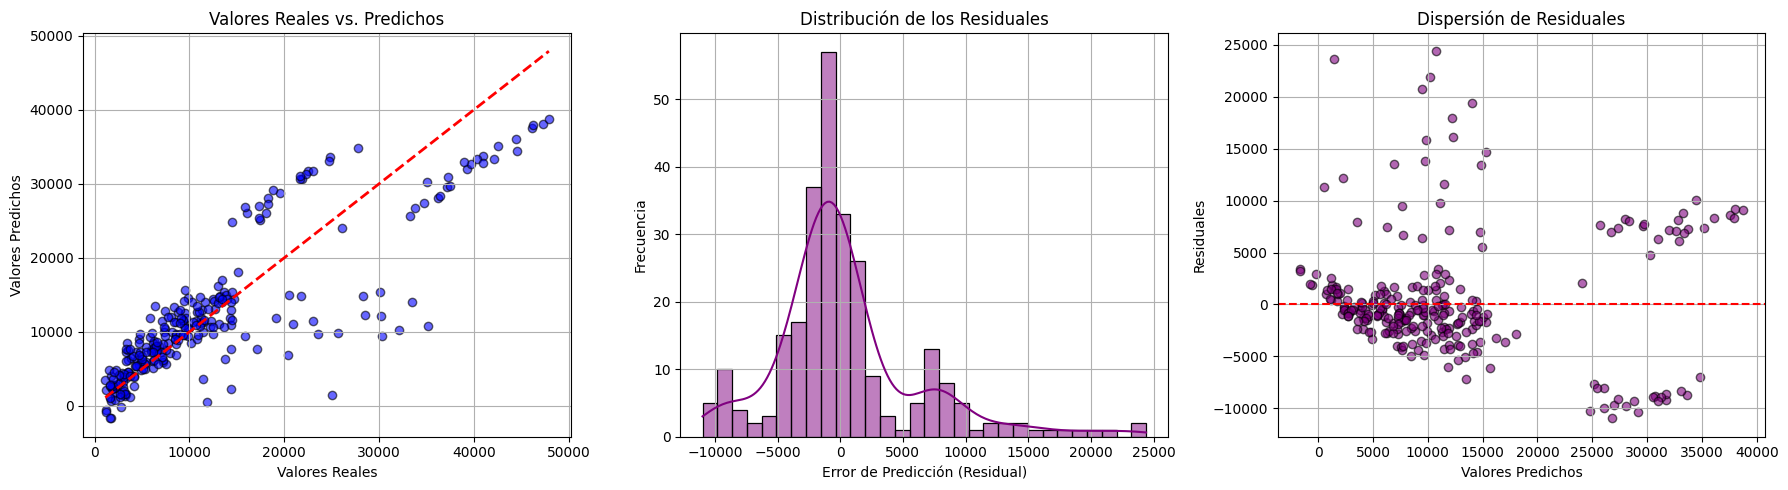


Entrenando y evaluando modelo: Linear Regression (log-transform)
Mejores parámetros para Linear Regression (log-transform): {}
MSE: 58691837.46, RMSE: 7661.06, R2: 0.51


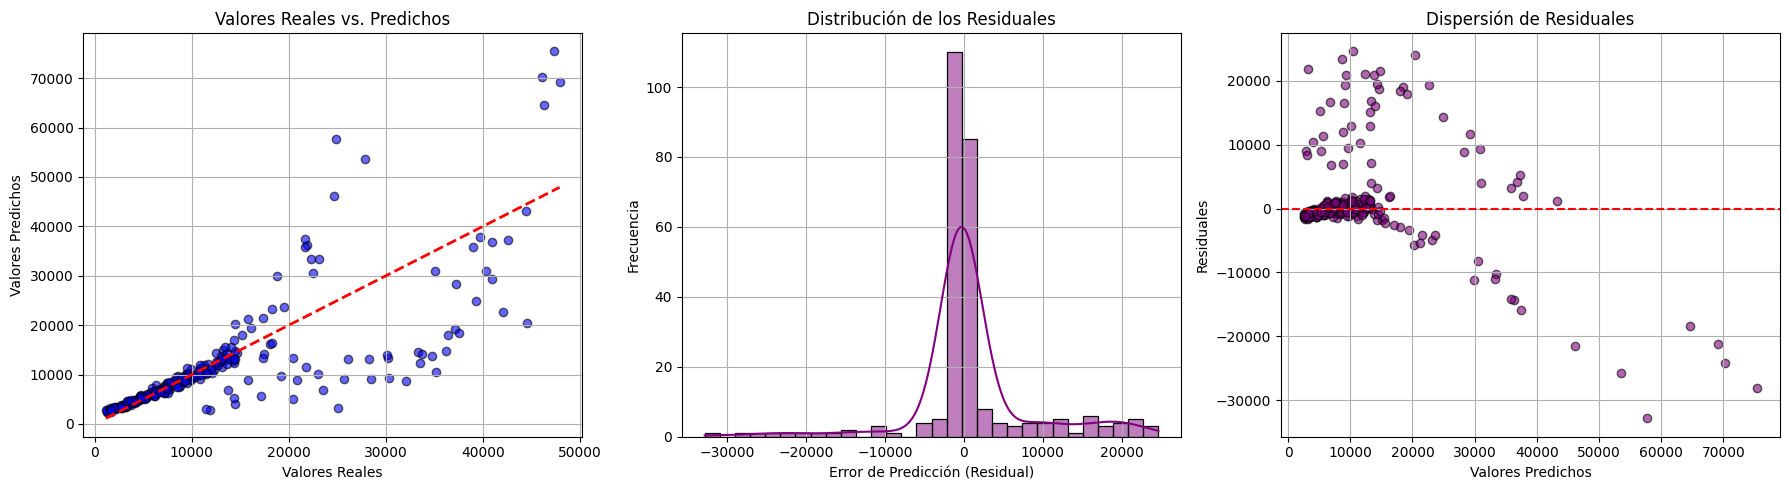


Entrenando y evaluando modelo: Decision Tree
Mejores parámetros para Decision Tree: {'regressor__max_depth': 10, 'regressor__min_samples_split': 10}
MSE: 31459059.21, RMSE: 5608.84, R2: 0.74


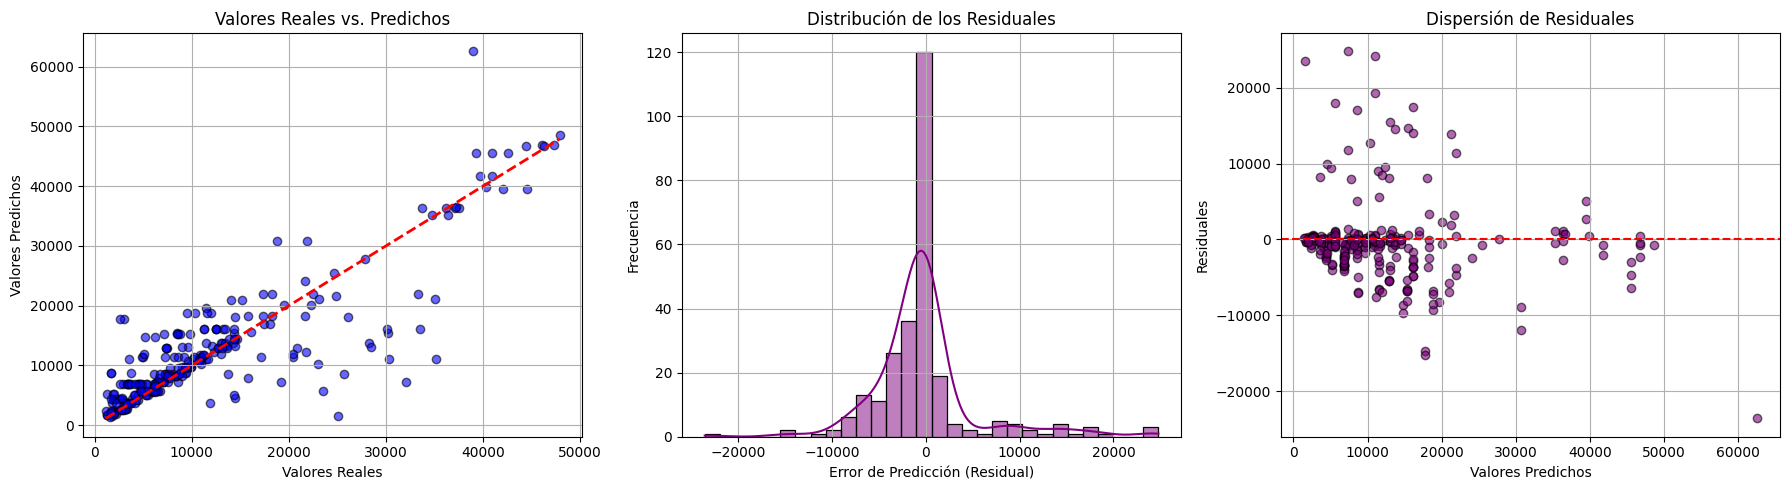


Entrenando y evaluando modelo: Decision Tree (log-transform)
Mejores parámetros para Decision Tree (log-transform): {'regressor__max_depth': 10, 'regressor__min_samples_split': 10}
MSE: 31230801.03, RMSE: 5588.45, R2: 0.74


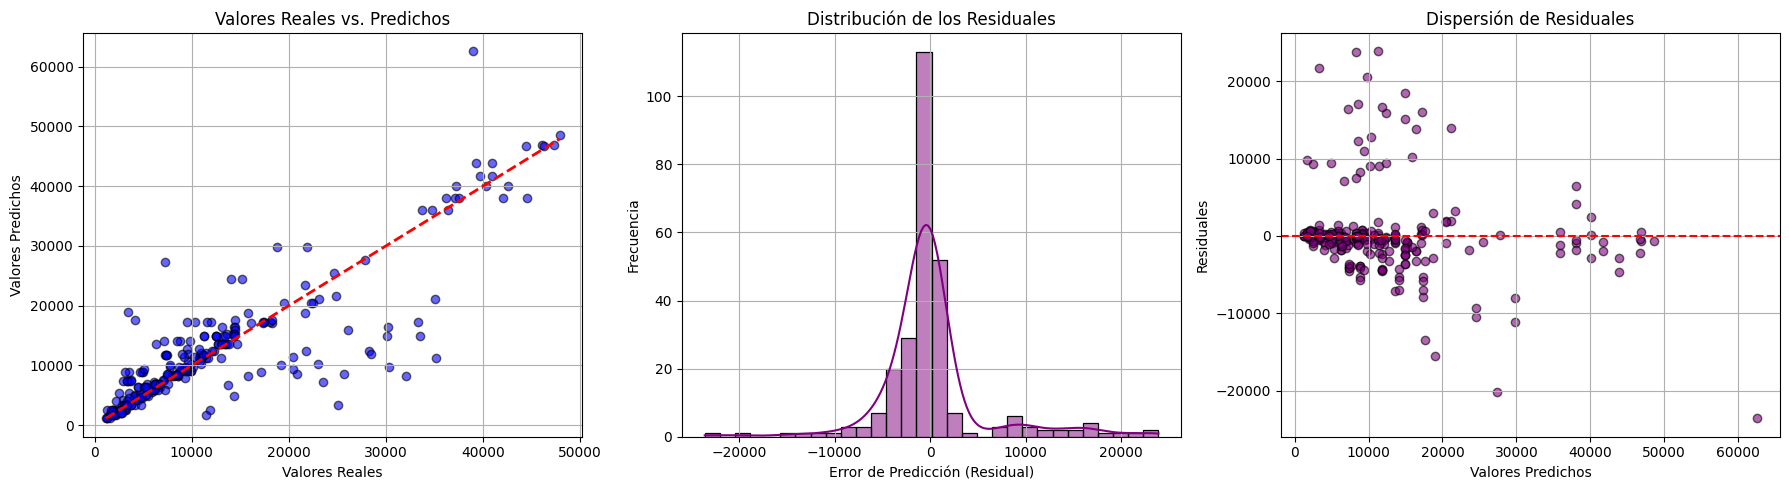


Entrenando y evaluando modelo: Random Forest
Mejores parámetros para Random Forest: {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
MSE: 25415117.45, RMSE: 5041.34, R2: 0.79


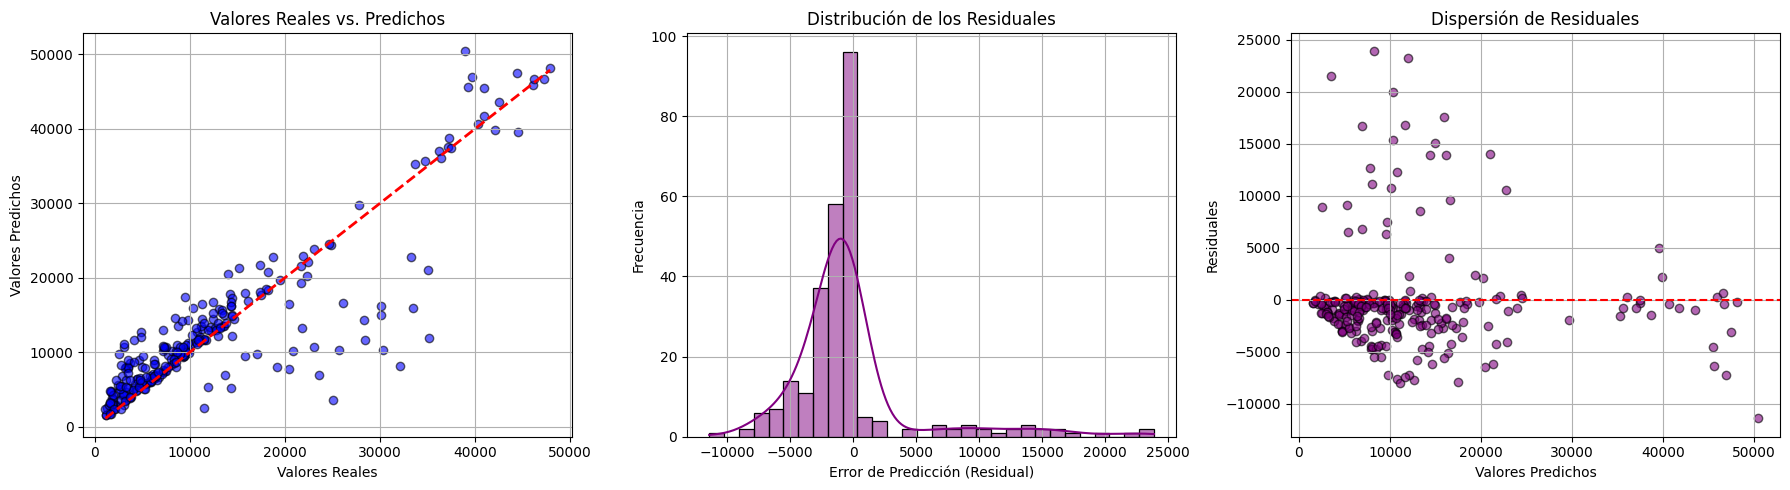


Entrenando y evaluando modelo: Random Forest (log-transform)
Mejores parámetros para Random Forest (log-transform): {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
MSE: 23497658.20, RMSE: 4847.44, R2: 0.81


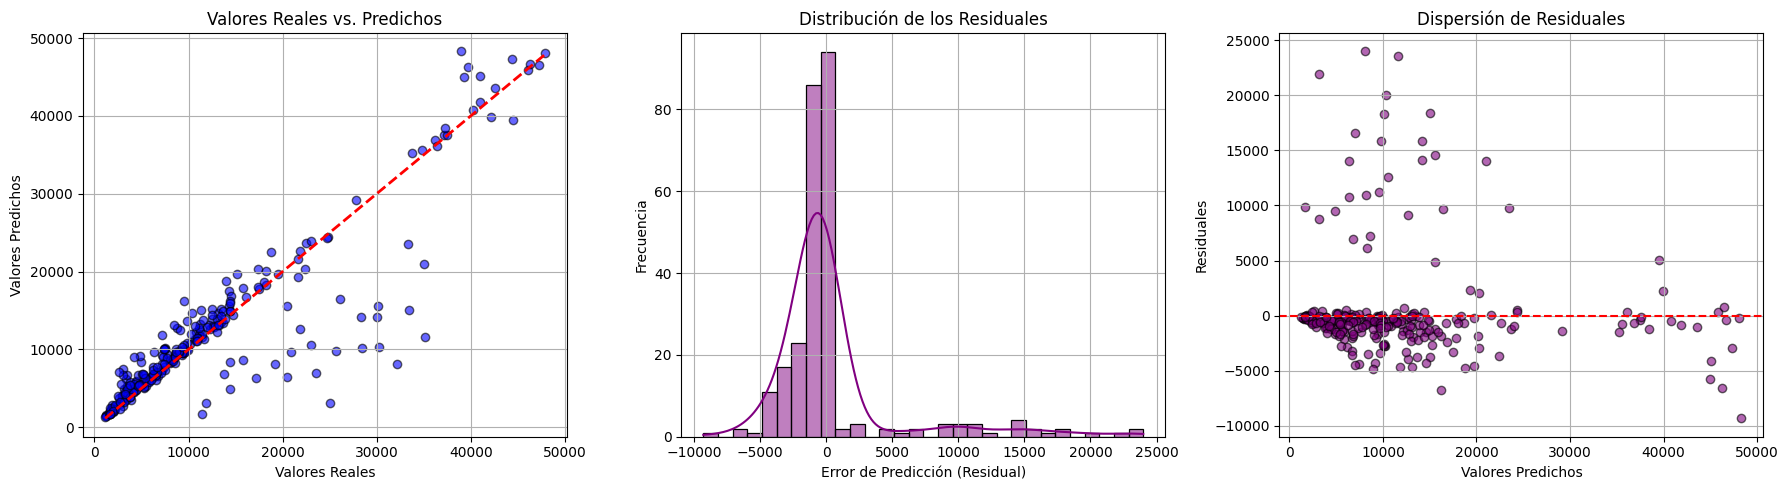


Entrenando y evaluando modelo: SVM
Mejores parámetros para SVM: {'regressor__C': 10, 'regressor__kernel': 'linear'}
MSE: 121251158.17, RMSE: 11011.41, R2: -0.00


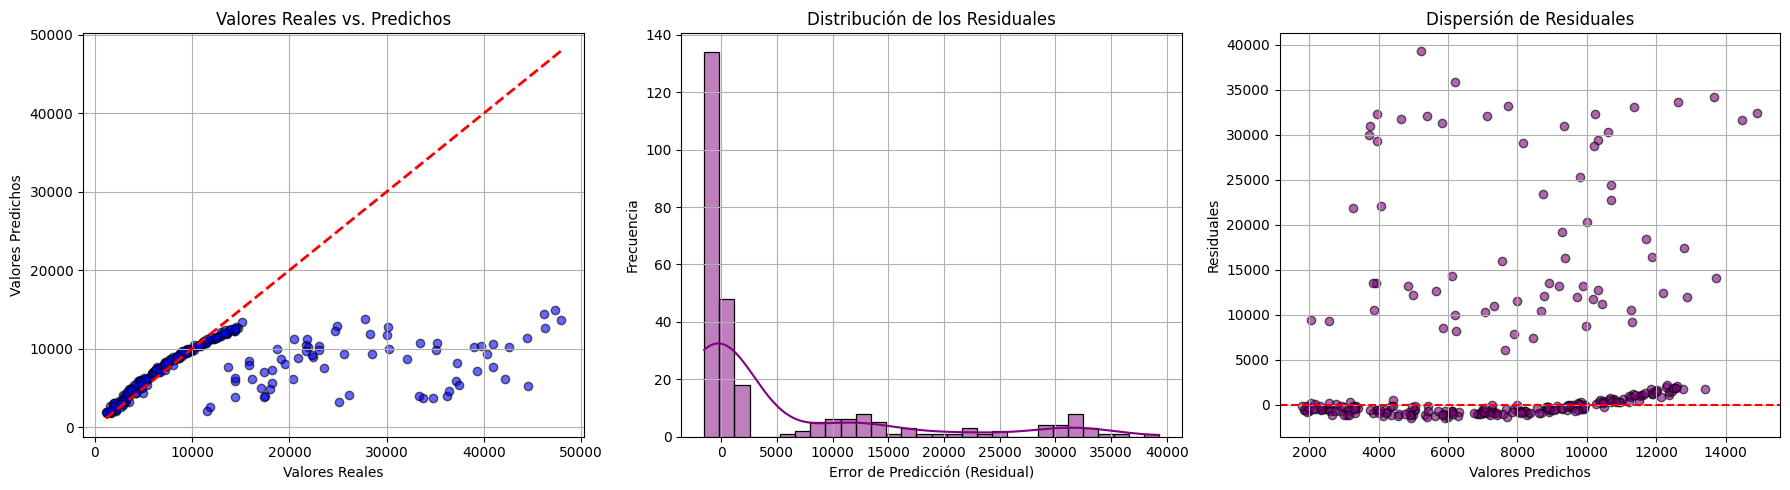


Entrenando y evaluando modelo: SVM (log-transform)
Mejores parámetros para SVM (log-transform): {'regressor__C': 10, 'regressor__kernel': 'rbf'}
MSE: 29299199.63, RMSE: 5412.87, R2: 0.76


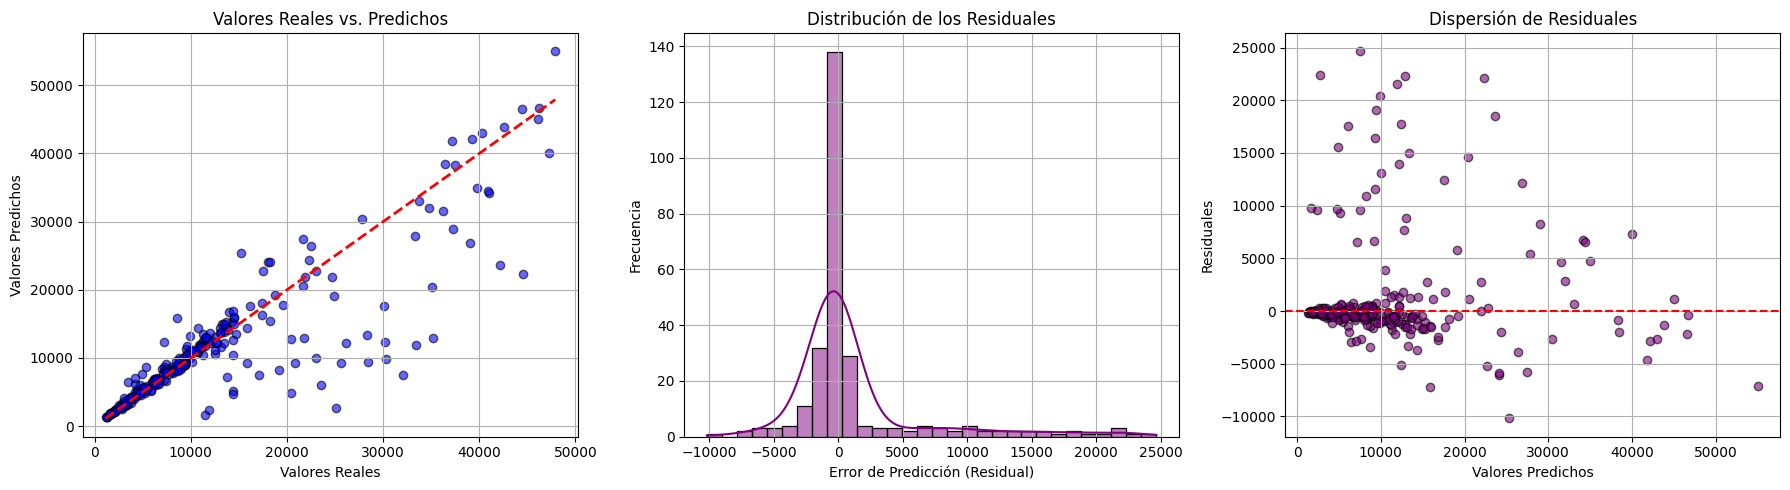


Entrenando y evaluando modelo: KNN
Mejores parámetros para KNN: {'regressor__n_neighbors': 3, 'regressor__weights': 'distance'}
MSE: 52190032.37, RMSE: 7224.27, R2: 0.57


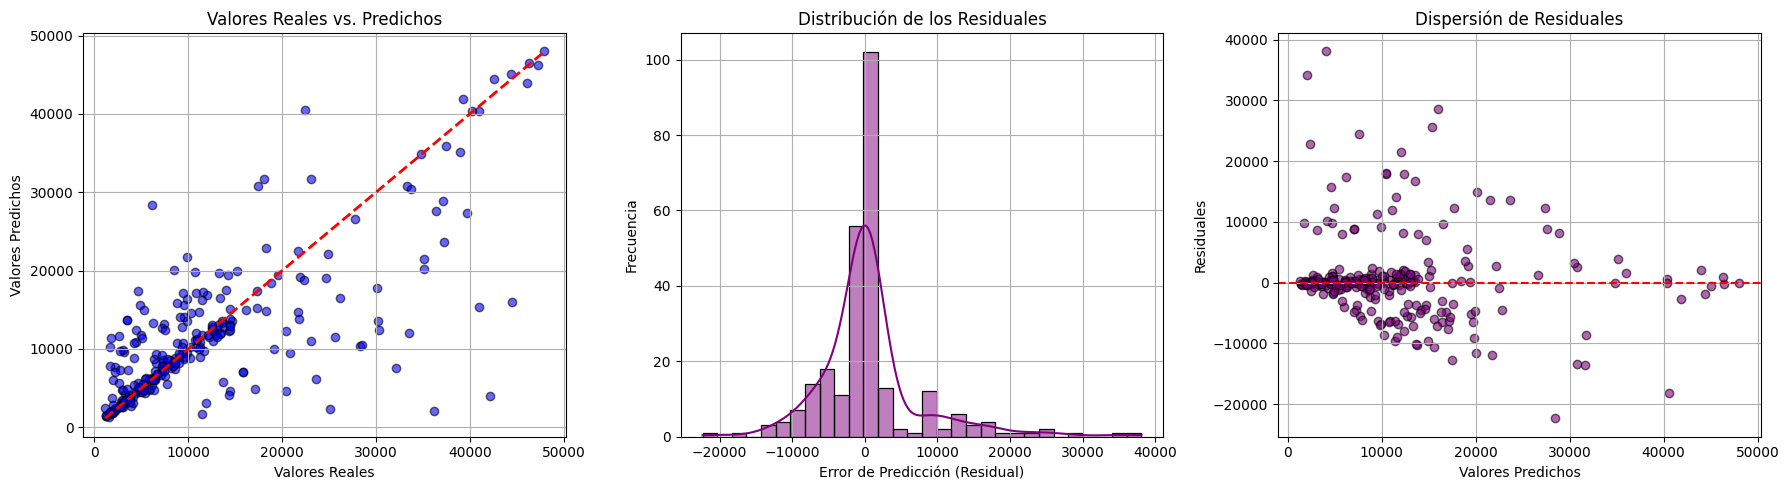


Entrenando y evaluando modelo: KNN (log-transform)
Mejores parámetros para KNN (log-transform): {'regressor__n_neighbors': 5, 'regressor__weights': 'distance'}
MSE: 52722661.40, RMSE: 7261.04, R2: 0.56


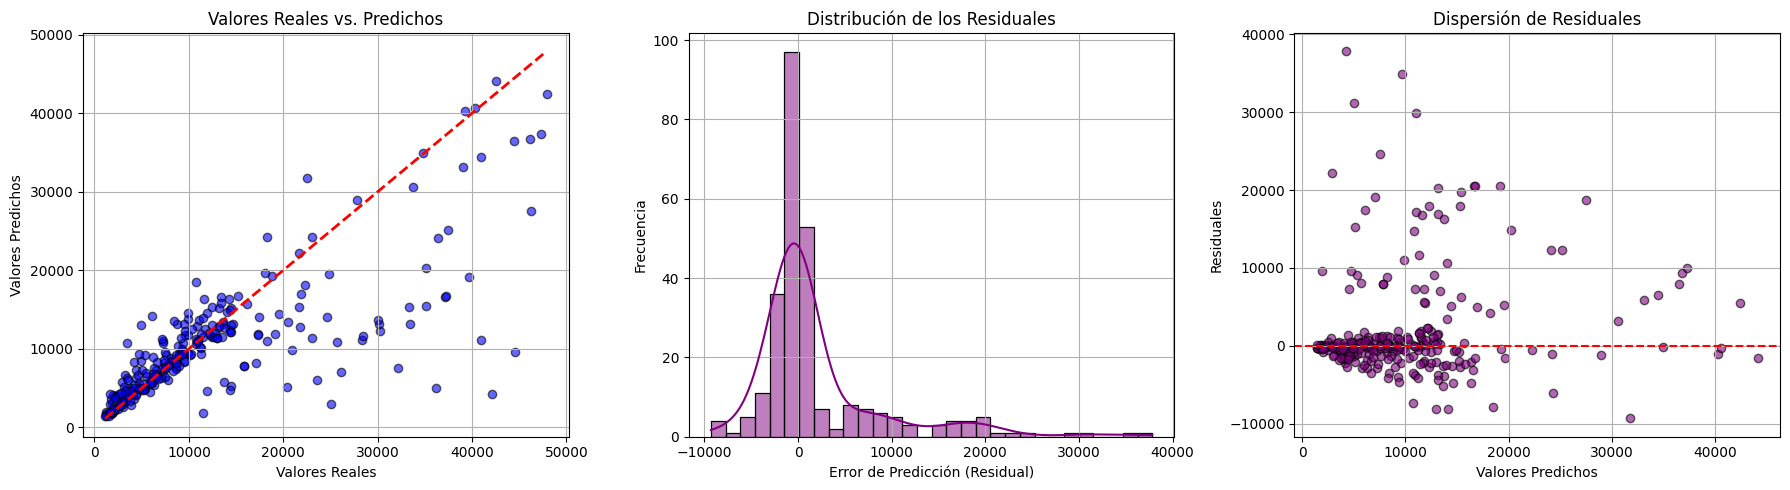

In [ ]:
# Ejecutar la búsqueda y evaluación de modelos
results = grid_search_and_evaluate(model_configs, X_train_no_outliers, y_train_no_outliers, X_val, y_val)

# Clasificación

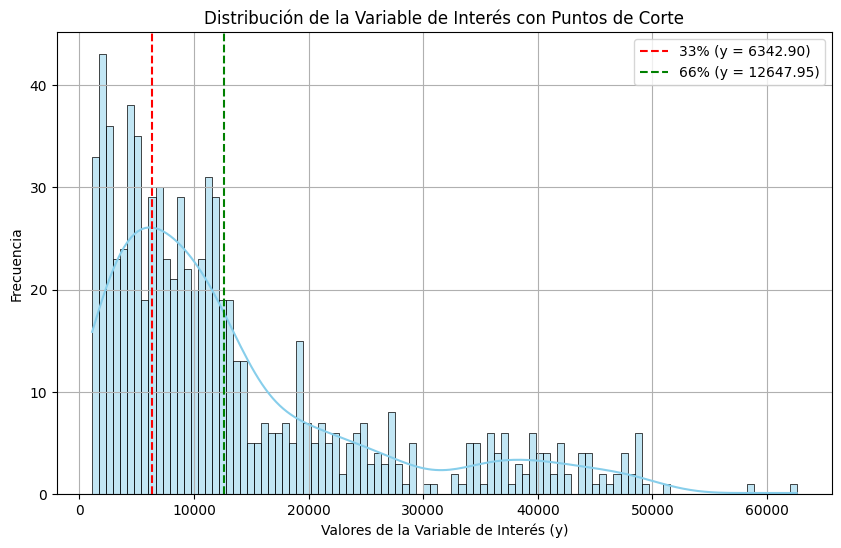

In [ ]:
# Calcular los puntos de corte en base a los cuantiles
cut_points = np.quantile(y_train_no_outliers, [0.33, 0.66])  # Para terciles
cut_points

plt.figure(figsize=(10, 6))

# Graficar la distribución de `y_train`
sns.histplot(y_train_no_outliers, bins=100, kde=True, color='skyblue')
plt.axvline(cut_points[0], color='red', linestyle='--', label=f'33% (y = {cut_points[0]:.2f})')
plt.axvline(cut_points[1], color='green', linestyle='--', label=f'66% (y = {cut_points[1]:.2f})')

# Etiquetas y título
plt.xlabel("Valores de la Variable de Interés (y)")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Variable de Interés con Puntos de Corte")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Calcular los límites de los cuantiles de y_train
quantile_limits = y_train_no_outliers.quantile([0, 1/3, 2/3, 1]).values  # Dividir en terciles

# Crear categorías en y_train y y_val usando los límites predefinidos
y_train_class = pd.cut(y_train_no_outliers, bins=quantile_limits, labels=[0, 1, 2], include_lowest=True)
y_val_class = pd.cut(y_val, bins=quantile_limits, labels=[0, 1, 2], include_lowest=True)

# Usar los mismos límites para categorizar y_test
y_test_class = pd.cut(y_test, bins=quantile_limits, labels=[0, 1, 2], include_lowest=True)

# Reemplazar NaN directamente con la clase más baja (0) sin agregar categorías
y_test_class = y_test_class.fillna(0).astype(int)

In [ ]:
classification_configs = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            'classifier__C': [0.1, 1, 10]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 10, 20],
            'classifier__min_samples_split': [2, 5]
        }
    },
    "SVM": {
        "model": SVC(),
        "params": {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf']
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['uniform', 'distance']
        }
    }
}


In [ ]:
def grid_search_classification(classification_configs, X_train, y_train, X_val, y_val):
    results = {}

    for model_name, config in classification_configs.items():
        print(f"\nEntrenando y evaluando modelo: {model_name}")

        # Crear pipeline para el modelo actual
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', config["model"])
        ])

        # Configurar GridSearchCV para el modelo
        grid_search = GridSearchCV(
            pipeline,
            param_grid=config["params"],
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        )

        # Entrenar GridSearchCV
        grid_search.fit(X_train, y_train)

        # Mejor pipeline
        best_pipeline = grid_search.best_estimator_

        # Predicciones en el conjunto de validación
        y_val_pred = best_pipeline.predict(X_val)

        # Calcular métricas de desempeño
        accuracy = accuracy_score(y_val, y_val_pred)
        print(f"Mejores parámetros para {model_name}: {grid_search.best_params_}")
        print(f"Exactitud en el conjunto de validación: {accuracy:.2f}")
        print("\nReporte de Clasificación:\n", classification_report(y_val, y_val_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_val, y_val_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Matriz de Confusión - {model_name}")
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.show()

        # Guardar resultados
        results[model_name] = {
            "best_params": grid_search.best_params_,
            "accuracy": accuracy
        }

    return results



Entrenando y evaluando modelo: Logistic Regression
Mejores parámetros para Logistic Regression: {'classifier__C': 0.1}
Exactitud en el conjunto de validación: 0.80

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91        98
           1       0.64      0.98      0.77        84
           2       1.00      0.51      0.68        86

    accuracy                           0.80       268
   macro avg       0.85      0.80      0.79       268
weighted avg       0.86      0.80      0.79       268



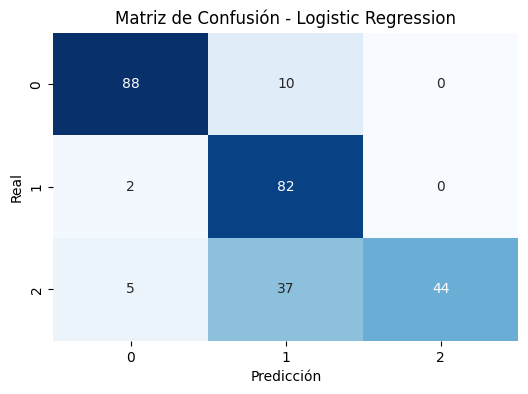


Entrenando y evaluando modelo: Decision Tree
Mejores parámetros para Decision Tree: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10}
Exactitud en el conjunto de validación: 0.81

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.88      0.85      0.86        98
           1       0.70      0.88      0.78        84
           2       0.88      0.71      0.79        86

    accuracy                           0.81       268
   macro avg       0.82      0.81      0.81       268
weighted avg       0.83      0.81      0.81       268



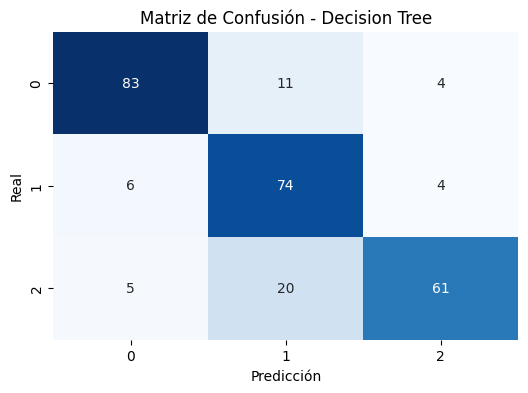


Entrenando y evaluando modelo: Random Forest
Mejores parámetros para Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Exactitud en el conjunto de validación: 0.86

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91        98
           1       0.73      0.96      0.83        84
           2       1.00      0.71      0.83        86

    accuracy                           0.86       268
   macro avg       0.88      0.86      0.86       268
weighted avg       0.88      0.86      0.86       268



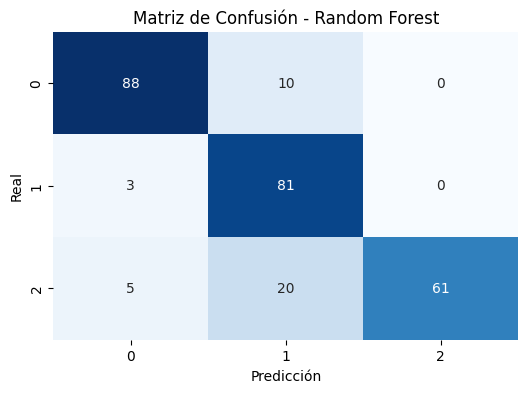


Entrenando y evaluando modelo: SVM
Mejores parámetros para SVM: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Exactitud en el conjunto de validación: 0.87

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91        98
           1       0.77      0.95      0.85        84
           2       0.97      0.72      0.83        86

    accuracy                           0.87       268
   macro avg       0.88      0.86      0.86       268
weighted avg       0.88      0.87      0.86       268



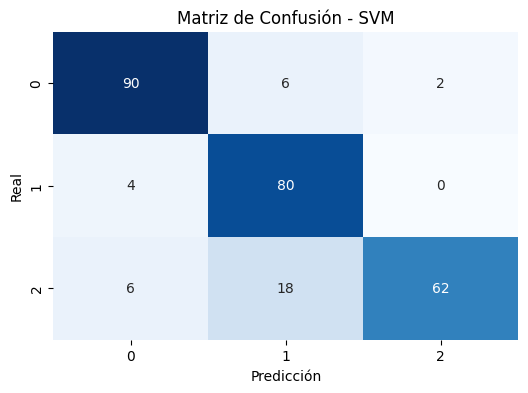


Entrenando y evaluando modelo: KNN
Mejores parámetros para KNN: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
Exactitud en el conjunto de validación: 0.80

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87        98
           1       0.69      0.92      0.79        84
           2       0.91      0.60      0.73        86

    accuracy                           0.80       268
   macro avg       0.82      0.80      0.80       268
weighted avg       0.82      0.80      0.80       268



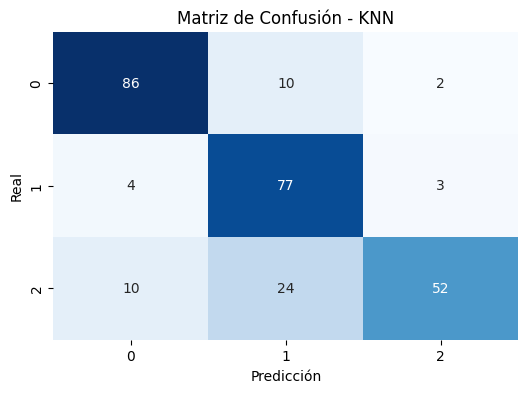

In [ ]:
# Ejecutar la búsqueda y evaluación de modelos de clasificación
classification_results = grid_search_classification(classification_configs, X_train_no_outliers, y_train_class, X_val, y_val_class)

# Test Dataset Regression

Desempeño del modelo en el conjunto de validación:
Mean Squared Error (MSE): 18561652.03
Root Mean Squared Error (RMSE): 4308.32
R-squared (R2): 0.90


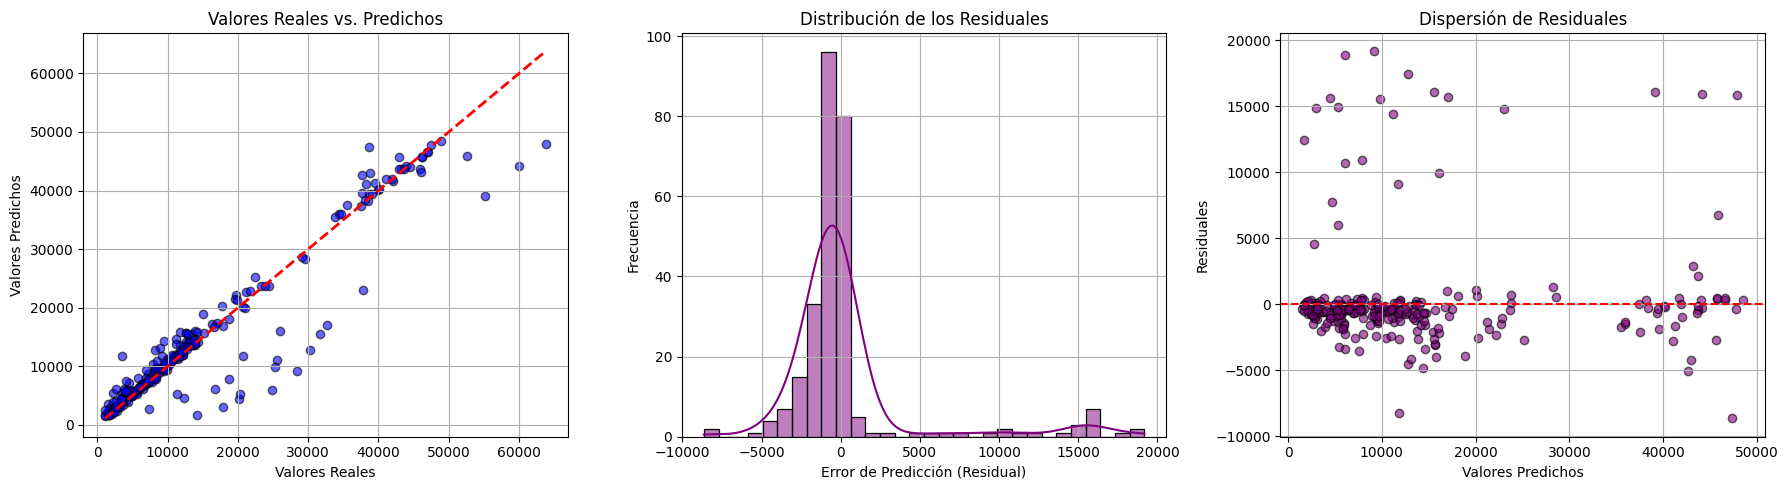

(18561652.02945995, 4308.323575297003, 0.8989875402135932)

In [ ]:
# Evaluación del modelo de regresión en el conjunto de prueba
best_rf_regressor_config = {
    "model": RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=200, random_state=42),
    "log_transform": True
}

# Llamar a train_and_evaluate para evaluar en el conjunto de prueba
train_and_evaluate(
    pipeline=Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', best_rf_regressor_config["model"])
    ]),
    X_train=X_train_no_outliers,
    y_train=y_train_no_outliers,
    X_val=X_test,
    y_val=y_test,
    log_transform=best_rf_regressor_config["log_transform"]
)


# Test Dataset Clasification

In [ ]:

def evaluate_final_model(classification_configs, X_train, y_train, X_test, y_test):
    results = {}
    final_pipeline = None

    for model_name, config in classification_configs.items():
        print(f"\nEvaluando modelo final en el conjunto de prueba: {model_name}")

        # Crear pipeline para el modelo actual con los mejores parámetros
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', config["model"])
        ])

        # Entrenar el pipeline en el conjunto de entrenamiento completo
        pipeline.fit(X_train, y_train)

        # Guardar el pipeline final
        final_pipeline = pipeline

        # Predicciones en el conjunto de prueba
        y_test_pred = pipeline.predict(X_test)

        # Calcular métricas de desempeño en el conjunto de prueba
        accuracy = accuracy_score(y_test, y_test_pred)
        print(f"Exactitud en el conjunto de prueba para {model_name}: {accuracy:.2f}")
        print("\nReporte de Clasificación:\n", classification_report(y_test, y_test_pred))

        # Matriz de confusión
        cm = confusion_matrix(y_test, y_test_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Matriz de Confusión - {model_name} en el conjunto de prueba")
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.show()

        # Guardar resultados
        results[model_name] = {
            "accuracy": accuracy,
            "classification_report": classification_report(y_test, y_test_pred, output_dict=True)
        }

    return results, final_pipeline



Evaluando modelo final en el conjunto de prueba: Random Forest Classifier
Exactitud en el conjunto de prueba para Random Forest Classifier: 0.90

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92        91
           1       0.88      0.91      0.89        86
           2       0.93      0.85      0.89        91

    accuracy                           0.90       268
   macro avg       0.90      0.90      0.90       268
weighted avg       0.90      0.90      0.90       268



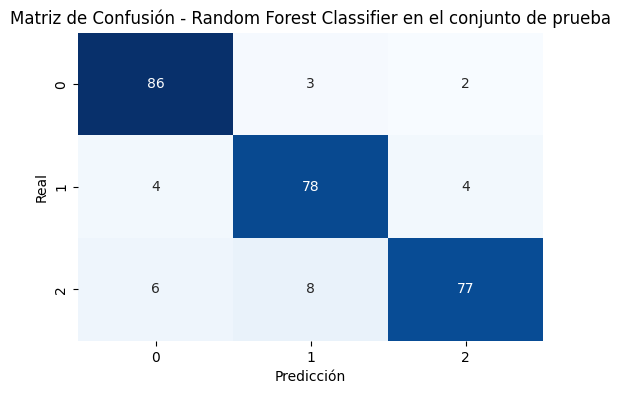

In [ ]:
# Configuración del modelo final con los mejores parámetros
classification_configs = {
    "Random Forest Classifier": {
        "model": RandomForestClassifier(max_depth=None, min_samples_split=5, n_estimators=100, random_state=42),
        "params": {}
    }
}

# Llamada a la función de evaluación en el conjunto de prueba
final_results, final_pipeline_classifier = evaluate_final_model(classification_configs, X_train_no_outliers, y_train_class, X_test, y_test_class)


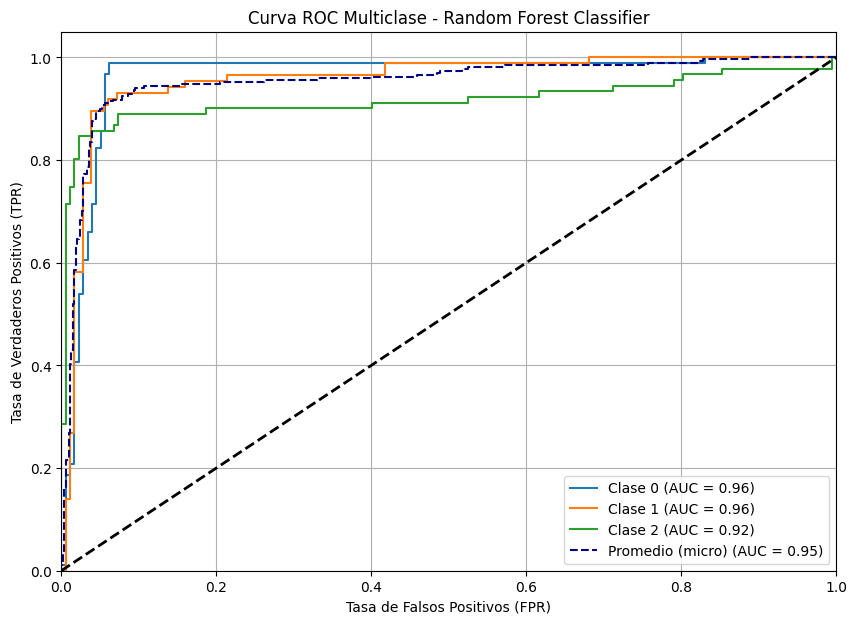

In [ ]:
# Binarizar las clases para calcular la ROC de forma multiclase
y_test_binarized = label_binarize(y_test_class, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Obtener probabilidades predichas del modelo para cada clase
y_test_proba = final_pipeline_classifier.predict_proba(X_test)

# Inicializar estructuras para almacenar resultados
fpr = {}
tpr = {}
roc_auc = {}

# Calcular ROC y AUC para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular ROC promedio
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_test_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Graficar la curva ROC para cada clase
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

# Graficar la curva ROC micro promedio
plt.plot(fpr["micro"], tpr["micro"], label=f'Promedio (micro) (AUC = {roc_auc["micro"]:.2f})', color='navy', linestyle='--')

# Agregar configuración del gráfico
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Multiclase - Random Forest Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


#Justificación de decisiones tomadas y conclusion

1. Mejor Modelo:** El árbol de decisión presentó el mejor rendimiento general debido a su alta precisión (98.15%) y balance en recall y F1-Score.
2. Aunque la regresión logística y KNN mostraron buenos resultados, el árbol de decisión destaca por su capacidad de capturar relaciones no lineales en los datos.
3.  Se optó por no eliminar outliers para conservar la representatividad de los datos reales y habiendo analizado que representa el 10%
4.  Se ajustaron los hiperparámetros utilizando GridSearchCV y RandomizedSearchCV para maximizar el rendimiento.
5.  Se utilizaron métricas como precisión, recall, F1-Score y ROC-AUC para una evaluación exhaustiva.